In [1]:
# default_exp tensorflow_tensorrt_conversion

In [2]:
#export
import tensorflow as tf
import tensorflow_addons as tfa

INFO:tensorflow:Using local port 18836
INFO:tensorflow:Using local port 15365
INFO:tensorflow:Using local port 21819
INFO:tensorflow:Using local port 16317
INFO:tensorflow:Using local port 15251
INFO:tensorflow:Using local port 19762
INFO:tensorflow:Using local port 18978
INFO:tensorflow:Using local port 18195
INFO:tensorflow:Using local port 19014
INFO:tensorflow:Using local port 20384


/home/justin/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# Create model

The TensorRT documentation specifically states that `InstanceNorm` and `ConvTranspose2d` are supported layers.

In [4]:
#export
def conv_layer(in_channels, out_channels, kernel_size, stride):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(out_channels,
                               kernel_size,
                               stride,
                               padding='same',
                               input_shape=(None, None, in_channels)),
        tfa.layers.InstanceNormalization(),
        tf.keras.layers.ReLU()
    ])

In [5]:
#export
def up_conv_layer(in_channels, out_channels, kernel_size, stride, scale_factor):
    return tf.keras.Sequential([
        conv_layer(in_channels, out_channels, kernel_size, stride),
        tf.keras.layers.Conv2DTranspose(out_channels,
                                        kernel_size,
                                        strides=2,
                                        padding='same',
                                        input_shape=(None, None, out_channels))
    ])

In [6]:
#export
def get_encoder(in_channels, layout_encoder):
    prev_out_channels = in_channels
    encoder = []
    for layout_layer in layout_encoder:
        layer = []
        for layout_conv in layout_layer:
            layer.append(conv_layer(prev_out_channels, *layout_conv))
            prev_out_channels = layout_conv[0]
        encoder.append(tf.keras.Sequential(layer))
    return tf.keras.Sequential(encoder)

In [7]:
#export
class UNET_TRT(tf.keras.Model):
    def __init__(self, encoder, out_channels):
        super().__init__()
        self.encoder = encoder
        self.decoder = self._get_decoder(encoder)
        self.last_conv = tf.keras.layers.Conv2D(out_channels, 
                                                kernel_size=3, 
                                                strides=1,
                                                padding='same',
                                                input_shape=(None, None, self.decoder[-1].output_shape[-1]))

    def _get_decoder(self, encoder):
        # Assumes each level of encoder shrinks by a factor of 2
        decoder = []
        for l in reversed(encoder.layers):
            in_channels = l.output_shape[-1]
            if len(decoder) > 0: in_channels += decoder[-1].output_shape[-1]
            decoder.append(up_conv_layer(in_channels,
                                         out_channels=l.output_shape[-1]//2,
                                         kernel_size=3,
                                         stride=1,
                                         scale_factor=2))
        return decoder

    def call(self, X, training=False):
        Xs = [X]
        for conv_down in self.encoder.layers:
            Xs.append(conv_down(Xs[-1]))
        X = Xs[-1][:,:,:,0:0] # Empty, but same size and dimension as last X
        for idx, conv_up in enumerate(self.decoder):
            X = conv_up(tf.concat([X, Xs[-(idx+1)]], 3))
        return self.last_conv(X)

In [8]:
in_channels  = 1
out_channels = 5
layout_encoder = [[[32,5,2]],
                  [[32,3,1],[32,3,2]],
                  [[64,3,1],[64,3,2]],
                  [[128,3,1],[128,3,2]]]
model = UNET_TRT(get_encoder(in_channels, layout_encoder), out_channels)

Now, check inference real quick

In [9]:
X = np.fromfile('batches/X0.raw', dtype=np.float32).reshape(1, 384, 512, 1)
X = tf.convert_to_tensor(X)

In [10]:
y = model(X)

This might include transfering data to gpu and also I'm not sure if output is synchronized or returned back to host. Also note that I think model can be statically compiled and frozen for better performance; come back to this later.

In [11]:
%%timeit
y = model(X)

16.7 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
y[0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.004479332>

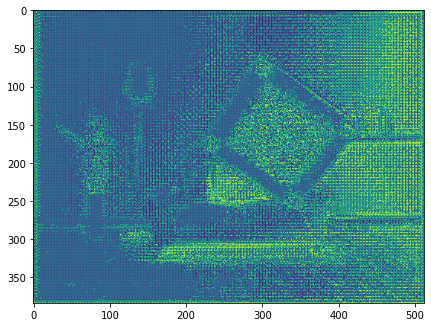

In [13]:
plt.figure(figsize=(7, 7))
plt.imshow(tf.argmax(y, axis=3)[0], vmin=0, vmax=4)

Save model for conversion to tensorrt

In [14]:
model.save('model.tf')

/home/justin/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2310: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/home/justin/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1388: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: model.tf/assets


# Tensorrt with trt_convert (32 bit)

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.compiler.tensorrt import trt_convert as trt

INFO:tensorflow:Using local port 20783
INFO:tensorflow:Using local port 20413
INFO:tensorflow:Using local port 18050
INFO:tensorflow:Using local port 23825
INFO:tensorflow:Using local port 20979
INFO:tensorflow:Using local port 24150
INFO:tensorflow:Using local port 24899
INFO:tensorflow:Using local port 15690
INFO:tensorflow:Using local port 16254
INFO:tensorflow:Using local port 20450


If memory growth is disabled tensorflow preallocates all GPU RAM and then I eventually run out of memory

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=2000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir='model.tf', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='model_32_trt.tf')

INFO:tensorflow:Linked TensorRT version: (7, 2, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 0)
INFO:tensorflow:Could not find TRTEngineOp_0_4 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_5 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_1 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_2 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_3 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngi

In [5]:
model = tf.saved_model.load('model_32_trt.tf', tags=[tag_constants.SERVING])
model = model.signatures['serving_default']

In [6]:
X = np.fromfile('batches/X0.raw', dtype=np.float32).reshape(1, 384, 512, 1)
X = tf.convert_to_tensor(X)

In [8]:
y = model(X)

In [9]:
%%timeit 
y = model(X)

3.63 ms ± 68.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
y['output_1'][0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.004479279>

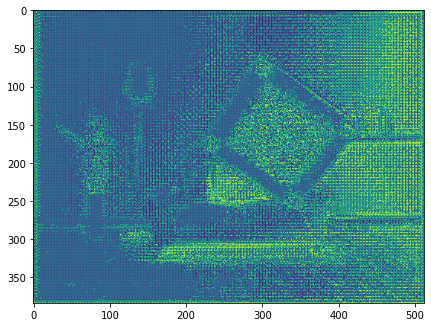

In [11]:
plt.figure(figsize=(7, 7))
plt.imshow(tf.argmax(y['output_1'], axis=3)[0], vmin=0, vmax=4)

# Tensorrt with trt_convert (16 bit)

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.compiler.tensorrt import trt_convert as trt

INFO:tensorflow:Using local port 15335
INFO:tensorflow:Using local port 24729
INFO:tensorflow:Using local port 17448
INFO:tensorflow:Using local port 15052
INFO:tensorflow:Using local port 23562
INFO:tensorflow:Using local port 18800
INFO:tensorflow:Using local port 24621
INFO:tensorflow:Using local port 15501
INFO:tensorflow:Using local port 24405
INFO:tensorflow:Using local port 22224


If memory growth is disabled tensorflow preallocates all GPU RAM and then I eventually run out of memory

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP16,
                                                               max_workspace_size_bytes=2000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir='model.tf', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='model_16_trt.tf')

INFO:tensorflow:Linked TensorRT version: (7, 2, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 0)
INFO:tensorflow:Could not find TRTEngineOp_0_4 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_5 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_1 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_2 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_3 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngi

In [4]:
model = tf.saved_model.load('model_16_trt.tf', tags=[tag_constants.SERVING])
model = model.signatures['serving_default']

In [5]:
X = np.fromfile('batches/X0.raw', dtype=np.float32).reshape(1, 384, 512, 1)
X = tf.convert_to_tensor(X)

In [6]:
y = model(X)

In [7]:
%%timeit 
y = model(X)

3.22 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
y['output_1'][0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0044021606>

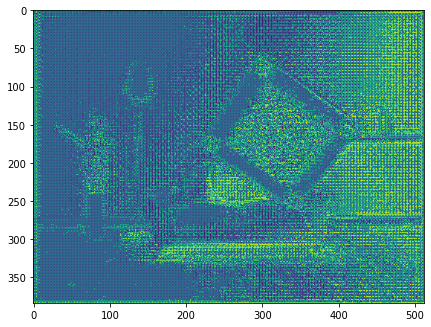

In [9]:
plt.figure(figsize=(7, 7))
plt.imshow(tf.argmax(y['output_1'], axis=3)[0], vmin=0, vmax=4)

# Tensorrt with trt_convert (8 bit)

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.compiler.tensorrt import trt_convert as trt

INFO:tensorflow:Using local port 21473
INFO:tensorflow:Using local port 18090
INFO:tensorflow:Using local port 20322
INFO:tensorflow:Using local port 15961
INFO:tensorflow:Using local port 22047
INFO:tensorflow:Using local port 15263
INFO:tensorflow:Using local port 23868
INFO:tensorflow:Using local port 20621
INFO:tensorflow:Using local port 19588
INFO:tensorflow:Using local port 22472


If memory growth is disabled tensorflow preallocates all GPU RAM and then I eventually run out of memory

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Must set up INT8 calibration

In [3]:
from test_fast_inference.data import *

In [4]:
ds_raw = (
    tf.data.Dataset.list_files('batches/*.raw', shuffle=False)
    .map(preprocess_raw)
)

In [5]:
def calibration_input_fn():
    for x in ds_raw:
        yield (x, )

In [6]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.INT8,
                                                               max_workspace_size_bytes=2000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir='model.tf', conversion_params=conversion_params)
converter.convert(calibration_input_fn=calibration_input_fn)
converter.save(output_saved_model_dir='model_8_trt.tf')

INFO:tensorflow:Linked TensorRT version: (7, 2, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 0)
INFO:tensorflow:Assets written to: model_8_trt.tf/assets


In [7]:
model = tf.saved_model.load('model_8_trt.tf', tags=[tag_constants.SERVING])
model = model.signatures['serving_default']

In [8]:
X = np.fromfile('batches/X0.raw', dtype=np.float32).reshape(1, 384, 512, 1)
X = tf.convert_to_tensor(X)

In [9]:
y = model(X)

In [11]:
%%timeit 
y = model(X)

3.16 ms ± 288 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
y['output_1'][0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=-0.004863739>

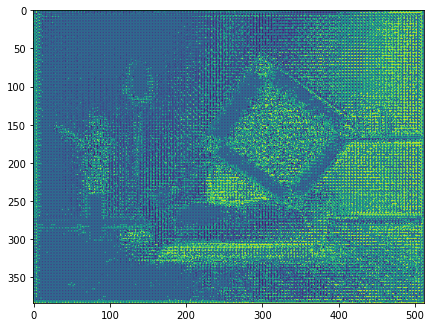

In [13]:
plt.figure(figsize=(7, 7))
plt.imshow(tf.argmax(y['output_1'], axis=3)[0], vmin=0, vmax=4)

# Compare

```
tensorflow      - val: -0.004479332 - time: 16.7 ms
TensorRT 32-bit - val: -0.004479279 - time: 3.63 ms
TensorRT 16-bit - val: -0.004402161 - time: 3.22 ms
TensorRT  8-bit - val: -0.004863739 - time: 3.16 ms
```

# Build

In [11]:
!nbdev_build_lib --fname tensorflow_tensorrt_conversion.ipynb

Converted tensorflow_tensorrt_conversion.ipynb.
